## Adding the Dolfinx library to the colab environment

In [ ]:
!wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"

## Importing the required libraries

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
import basix.ufl
import dolfinx.fem.petsc
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
from time import time
import os

## Setting material properties

In [ ]:
log.set_log_level(log.LogLevel.WARNING)
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

kap_by_mu = ScalarType(10.**3)


# Material Properties
mu1 = ScalarType(0.09)
mu2 = ScalarType(0.01)
mu_pr = ScalarType(kap_by_mu*(mu1 + mu2))
alph1 = ScalarType(1)
alph2 = ScalarType(1)
m1 = ScalarType(0.45)
m2 = ScalarType(0.05)
a1 = ScalarType(1)
a2 = ScalarType(1)
K1 = ScalarType(0)
K2 = ScalarType(0)
bta1 = ScalarType(1)
bta2 = ScalarType(1)
eta0 = ScalarType(0.5)
etaInf = ScalarType(0.0)
N0 = ScalarType(0.5)

## Generating the mesh with element size $h$

In [ ]:
W, L = 4.0, 7.5                                                                   #making use of symmetry
g = 0.5


h = 0.05
domain = mesh.create_box(comm = comm,points=
                             [np.array([0,0,0]), np.array([W,L,g])],n=[int(W/(8*h))
                             ,int(L/(8*h)),int(g/(8*h))+1], cell_type=mesh.CellType.tetrahedron
                               , ghost_mode=mesh.GhostMode.shared_facet)

xdmf = dolfinx.io.XDMFFile(domain.comm, "mesh.xdmf", "w")
xdmf.write_mesh(domain)
xdmf.close()

## Defining the function spaces and trial and test functions

In [ ]:
V = fem.functionspace(domain, ("CR", 1, (domain.geometry.dim,)))
un = fem.Function(V, name="displacement")
u = fem.Function(V)
utrial = ufl.TrialFunction(V)
delu = ufl.TestFunction(V)

el_q = basix.ufl.quadrature_element(domain.topology.cell_name(),
                                    value_shape=(domain.geometry.dim,domain.geometry.dim)
                                    ,scheme="default", degree=2,symmetry=True)
VQe = dolfinx.fem.functionspace(domain, el_q)
Cvtrial = fem.Function(VQe)
Cvn = fem.Function(VQe, name='Cvn')
Cv = fem.Function(VQe, name='Cv')


Vplot = fem.functionspace(domain, ("CG", 1, (domain.geometry.dim,)))
VQePlot = fem.functionspace(domain, ("Discontinuous Lagrange", 0, (domain.geometry.dim,domain.geometry.dim)))
uplot = fem.Function(Vplot, name='disp')
Cvplot = fem.Function(VQePlot, name='Cv')
uiter = fem.Function(V, name='uk_1')
Cviter = fem.Function(VQe, name='Cvk1')
error_cv = fem.Function(Cvtrial.function_space)

## Setting the Dirichlet part of the boundary conditions

In [ ]:
def left(x):
    return np.isclose(x[0], 0)

def front(x):
    return np.isclose(x[0], W)

def top(x):
    return np.isclose(x[1], L)

def bottom(x):
    return np.isclose(x[1], 0)


fdim = domain.topology.dim -1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
front_facets = mesh.locate_entities_boundary(domain, fdim, front)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)
bottom_facets = mesh.locate_entities(domain, fdim, bottom)

strtch = ScalarType(0.)

dofs_bottom = fem.locate_dofs_topological(V.sub(1), fdim, bottom_facets)

dofs_top = fem.locate_dofs_topological(V.sub(1), fdim, top_facets)
dofs_top2 = fem.locate_dofs_topological(V.sub(0), fdim, top_facets)
dofs_top3 = fem.locate_dofs_topological(V.sub(2), fdim, top_facets)


bct = fem.dirichletbc(strtch, dofs_top, V.sub(1))
bcr = fem.dirichletbc(ScalarType(0), dofs_top2, V.sub(0))
bcr2 = fem.dirichletbc(ScalarType(0), dofs_top3, V.sub(2))
bcb = fem.dirichletbc(ScalarType(0), dofs_bottom, V.sub(1))

bcs = [bct, bcr, bcr2, bcb]

## Marking the facets

In [ ]:
marked_facets = np.hstack([bottom_facets, top_facets, left_facets])
marked_values = np.hstack([np.full_like(bottom_facets, 1),
                           np.full_like(top_facets, 2),
                           np.full_like(left_facets, 3)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, domain.topology.dim -1,
                          marked_facets[sorted_facets],
                          marked_values[sorted_facets])


metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', domain=domain,
                 subdomain_data=facet_tag, metadata=metadata)
dS = ufl.Measure('dS', domain=domain, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)

def norm_L2(comm, v):
    """Compute the L2(O)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(ufl.inner(v, v) * dx)), op=MPI.SUM))

## Defining stored energy function

In [ ]:
def freeEnergy(u, Cv):
    """[summary]
        Given, `u` and `Cv` this function
        calculates the sum of equilibrium and non-equilibrium
        free energies
    Args:
        u ([dolfin.Function]): [FE displacement field]
        Cv ([dolfin.Function]): [FE internal variable]

    Returns:
        [psiEq + psiNEq]: [Sum of energies of type `ufl.algebra.Sum`]
    """
    F = (ufl.Identity(len(u)) + ufl.grad(u))
    C = (F.T * F)
    J = (ufl.det(F))
    I1 = (ufl.tr(C))
    Ce = (C*ufl.inv(Cv))
    Ie1 = (ufl.tr(Ce))


    psiEq = 3**(1-alph1)/(2.*alph1) * mu1 * (I1**alph1 - 3**alph1) + 3**(1-alph2) / \
        (2.*alph2) * mu2 * (I1**alph2 - 3**alph2) - \
        (mu1 + mu2) * ufl.ln(J) + mu_pr/2*(J-1)**2

    psiNeq = 3**(1-a1)/(2.*a1) * m1 * (Ie1**a1 - 3**a1) + 3**(1-a2)/(2.*a2) * \
        m2 * (Ie1**a2 - 3**a2) - (m1 + m2) * \
        ufl.ln(J)

    return psiEq + psiNeq


## Defining the evolution equation

In [ ]:
def evolEqG(u, Cv):
    """[summary]
        Given `u` and `Cv` this function calculates the
        RHS of the evolution equation G(C, Cv) as described
        in the paper referenced above
    Args:
        u ([dolfin.Function]): [FE displacement field]
        Cv ([dolfin.Function]): [FE internal variable]

    Returns:
        [G(C(u), Cv)]: [RHS of the evolution equation]
    """
    F = (ufl.Identity(len(u)) + ufl.grad(u))
    C = (F.T * F)
    I1 = (ufl.tr(C))
    Iv1 = (ufl.tr(Cv))
    Ce = (C*ufl.inv(Cv))
    Ie1 = (ufl.tr(Ce))
    Ie2 = 1/2.*((Ie1)**2 - ufl.tr(ufl.dot(Ce,Ce)))

    # define etaK
    A2 = m1*(Ie1/3)**(a1 - 1) + m2 * (Ie1/3)**(a2 - 1)


    eta0f = eta0  + (N0 - eta0)*(ufl.tanh(Iv1**bta1 - 3**bta1 - K1) + np.tanh(K1))/(1 + np.tanh(K1))

    etagen = (etaInf + (eta0f - etaInf)/(1 + (K2 *((Ie1**2/3. - Ie2)*A2**2))**bta2))


    G = A2 / (etagen) * (C - Ie1/3. * Cv)
    G_temp = G
    G_temp = local_project(G_temp, VQe)
    return G_temp


## Defining a function for Runge–Kutta method

In [ ]:
def k_terms(dt, u, un, Cvn):
    """[summary]
        Given u(tn), Cv(tn), u(t_k, r) and dt this function
        calculates the terms k_i (i=1 to 6) as described in
        the paper above
    Args:
        dt ([float]): [time increment]
        u ([dolfin.Function]): [FE displacement field]
        un ([dolfin.Function]): [FE displacement field at t=tn]
        Cvn ([dolfin.Function]): [FE internal variable at t=tn]

    Returns:
        [k1 + ... + k6]: [ufl.algebra.Sum]
    """
    un_quart = un + 0.25*(u-un)
    un_half = un + 0.5*(u-un)
    un_thr_quart = un + 0.75 * (u-un)

    k1 = evolEqG(un, Cvn)
    k1.x.scatter_forward()

    k2 = evolEqG(un_half, Cvn + k1*dt/2)
    k2.x.scatter_forward()

    k3 = evolEqG(un_quart, Cvn + 1./16*dt*(3*k1+k2))
    k3.x.scatter_forward()

    k4 = evolEqG(un_half, Cvn + dt/2.*k3)
    k4.x.scatter_forward()

    k5 = evolEqG(un_thr_quart, Cvn + 3./16*dt*(-k2 + 2.*k3 + 3.*k4))
    k5.x.scatter_forward()

    k6 = evolEqG(u, Cvn + (k1 + 4.*k2 + 6.*k3 - 12.*k4 + 8.*k5) * dt/7.)
    k6.x.scatter_forward()

    kfinal = dt/90*(7*k1 + 32*k3 + 12*k4 + 32*k5 + 7*k6)
    kfinal = local_project(kfinal, VQe)
    kfinal.x.scatter_forward()

    return kfinal


## Defining a function to do an interpolation for any field

In [ ]:
def local_project(v, V):
    """[summary]
        Helper function to do a interpolation
    Args:
        v ([dolfin.Funcion]): [function to be projected]
        V ([dolfin.Function]): [target `dolfin.FunctionSpace` to be projected on]

    Returns:
        [dolfin.Function]: [target function after projection]
    """
    expr = fem.Expression(v, V.element.interpolation_points(), comm)
    u = fem.Function(V)
    u.interpolate(expr)
    u.x.scatter_forward()
    return u

## Setting the initial conditions

In [ ]:
def identity_np(x):
    values = np.zeros((domain.geometry.dim*domain.geometry.dim,
                      x.shape[1]), dtype=np.float64)
    values[0,:] = 1
    values[4,:] = 1
    values[8,:] = 1
    return values

# initialize the displacements and the internal variable, we may need sth for parallel computation
un.x.array[:] = 0.
Cv.interpolate(identity_np)
Cv.x.scatter_forward()
Cvn.interpolate(identity_np)
Cvn.x.scatter_forward()

## Weak form of PDE for displacement field

In [ ]:
qvals = (mu1+mu2+m1+m2)
h = ufl.FacetArea(domain)
h_avg = (h('+') + h('-')) / 2.0
n=ufl.FacetNormal(domain)
a_uv = ufl.derivative(freeEnergy(u, Cv), u, delu)*dx + qvals / h_avg * ufl.inner(ufl.jump(u), ufl.jump(delu)) * dS
Jac = ufl.derivative(a_uv, u, utrial)

## Defining a class for solving nonlinear PDEs

In [ ]:
class NonlinearPDE_SNESProblem:
    def __init__(self, F, u, bc, J):
        #V = u.function_space
        #du = ufl.TrialFunction(V)
        self.L = fem.form(F)
        self.a = fem.form(J)
        self.bc = bc
        self._F, self._J = None, None
        self.u = u

    def F(self, snes, x, F):
        """Assemble residual vector."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        #with x.localForm() as _x:
            #self.u.x.array[:] = _x.array_r
        x.copy(self.u.x.petsc_vec)
        self.u.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        with F.localForm() as f_local:
            f_local.set(0.0)
        fem.petsc.assemble_vector(F, self.L)
        fem.petsc.apply_lifting(F, [self.a], bcs=[self.bc], x0=[x], alpha=-1.0)
        F.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(F, self.bc, x, -1.0)

    def J(self, snes, x, J, P):
        """Assemble Jacobian matrix."""
        J.zeroEntries()
        fem.petsc.assemble_matrix(J, self.a, bcs=self.bc)
        J.assemble()

## Creating SNES solver and its customizations

In [ ]:
# Create nonlinear problem
problem = NonlinearPDE_SNESProblem(a_uv, u, bcs, Jac)

b = la.create_petsc_vector(V.dofmap.index_map, V.dofmap.index_map_bs)
J = fem.petsc.create_matrix(problem.a)


# Create Newton solver and solve
solver = PETSc.SNES().create()
opts = PETSc.Options()
opts['snes_linesearch_type'] = 'basic'
opts['snes_monitor'] = None
opts['snes_linesearch_monitor'] = None
solver.setFromOptions()

solver.setFunction(problem.F, b)
solver.setJacobian(problem.J, J)


solver.setTolerances(rtol=1.0e-9, max_it=6)
solver.getKSP().setType("preonly")
solver.getKSP().setTolerances(rtol=1.0e-9)
solver.getKSP().getPC().setType("lu")
solver.getKSP().getPC().setFactorSolverType("mumps")

## Setting the time step parameters

In [ ]:
Lambda_max = 1.5
Lambda_dot = 10**(0)
ldot = Lambda_dot * L
n_interval = 80
timeVals = np.linspace(0, (Lambda_max -1)*L / ldot, n_interval)
dt = timeVals[1] - timeVals[0]
stretchVals = np.hstack(ldot*timeVals[:len(timeVals)])
dh = (stretchVals[1] - stretchVals[0])


wfil = io.XDMFFile(domain.comm, "paraview/disp_Visco.xdmf", "w")
wfil.write_mesh(domain)

if rank == 0:
    rfile =  open(f'Visco_test_results.txt', 'a')
    rfile.write("time      displacement      stretch      force\n")

## Solving the problem over several time steps via a staggered scheme

In [ ]:
for i, tk in enumerate(timeVals):
    bct.g.value[...] = ScalarType(stretchVals[i])
    if domain.comm.rank == 0:
        print('u_3: {}'.format(float(bct.g.value)))


    solver.solve(None, u.x.petsc_vec)
    u.x.scatter_forward()

    Av = Cvn + k_terms(dt, u, un, Cvn)
    Cviter = local_project(Av/(ufl.det(Av))**(1/3), VQe)


    Cviter.x.scatter_forward()
    error_cv.x.array[:] = Cvtrial.x.array - Cviter.x.array

    norm_delCv = norm_L2(comm, error_cv)
    if domain.comm.rank == 0:
        print(norm_delCv)
    iterCount = 0


    while norm_delCv > 1.e-5 and iterCount <= 10:
        u.x.scatter_forward()
        if domain.comm.rank == 0:
            print('Staggered scheme started')
        Cvtrial.x.array[:] = Cviter.x.array
        Cv.x.array[:] = Cviter.x.array
        solver.solve(None, u.x.petsc_vec)
        u.x.scatter_forward()

        uiter.x.array[:] = u.x.array
        Av = Cvn + k_terms(dt, u, un, Cvn)
        Cviter = local_project(Av/(ufl.det(Av))**(1/3), VQe)
        Cviter.x.scatter_forward()
        iterCount += 1
        error_cv.x.array[:] = Cvtrial.x.array - Cviter.x.array

        norm_delCv = norm_L2(comm, error_cv)
        if domain.comm.rank == 0:
            print("Staggered Iteration: {}, Norm = {}".format(iterCount, norm_delCv))


    un.x.array[:] = u.x.array
    Cvn.x.array[:] = Cviter.x.array


    # post-processing
    be = fem.petsc.assemble_vector(fem.form(a_uv)).getArray()
    fint=be.copy()
    Fx=domain.comm.allreduce(np.sum(fint[dofs_top]), op=MPI.SUM)
    uplot.x.array[:] = (local_project(un, Vplot)).x.array
    wfil.write_function(uplot, tk)


    if rank == 0:
        rfile = open(f'Visco_test_results.txt', 'a')
        rfile.write("%s %s %s %s\n" % (str(tk),
                                                str(stretchVals[i]),
                                                str(stretchVals[i]/L+1),
                                                str(Fx)))



wfil.close()
rfile.close()

## Results

Snapshots of the specimen at the beginning and end of the loading

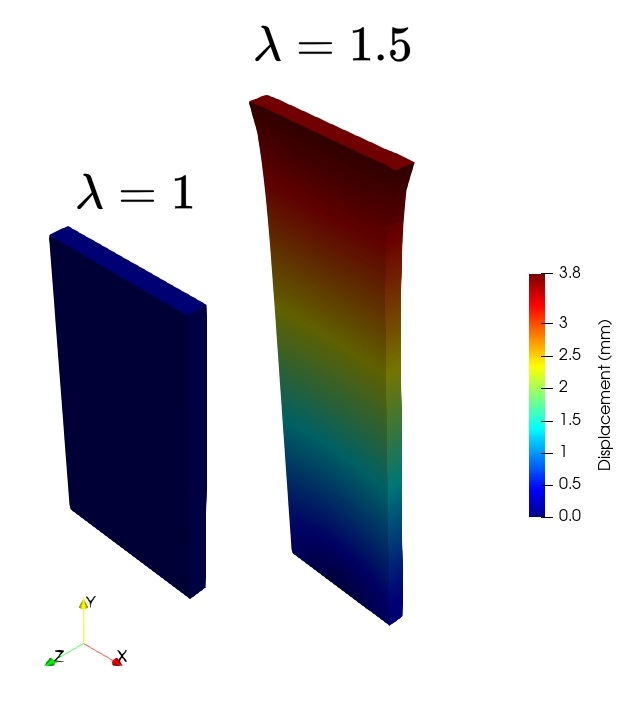